Import Modules

In [43]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, LSTM, Dropout
warnings.filterwarnings('ignore')



TESS Toronto - Load the Dataset

In [44]:
train_paths = []
train_labels = []
for dirname, _, filenames in os.walk('train_data'):
    for filename in filenames:
        train_paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        train_labels.append(label.lower())

print('TESS Toronto Dataset is loaded')

TESS Toronto Dataset is loaded


In [45]:
train_paths[:10]

['train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_beg_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bite_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_boat_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bone_angry.wav',
 'train_data\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_book_angry.wav']

In [46]:
train_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

In [47]:
# Create a dataframe for the train data
df_train = pd.DataFrame()
df_train['speech'] = train_paths
df_train['label'] = train_labels
df_train.head()

,speech,label
0,train_data\TESS Toronto emotional speech set d...,angry
1,train_data\TESS Toronto emotional speech set d...,angry
2,train_data\TESS Toronto emotional speech set d...,angry
3,train_data\TESS Toronto emotional speech set d...,angry
4,train_data\TESS Toronto emotional speech set d...,angry


In [48]:
df_train['label'].value_counts()

angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: label, dtype: int64

Exploratory Data Analysis

<AxesSubplot: xlabel='label', ylabel='count'>

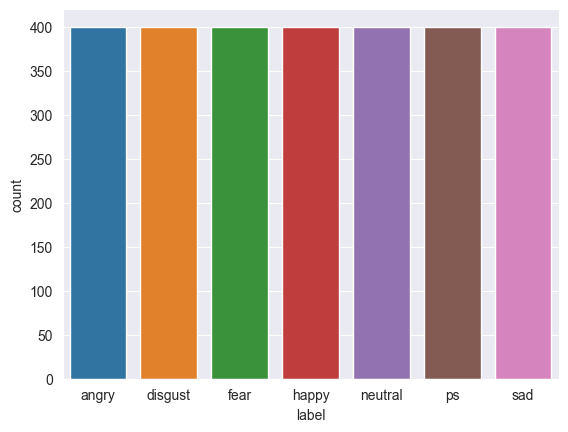

In [49]:
sns.countplot(df_train, x='label')

In [50]:
def waveform(data, sample_rate, emotion):
    plt.figure(figsize=(10,4))
    plt.title("Waveplot for audio with {} emotion".format(emotion), size=20)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()

def spectrogram(data, sample_rate, emotion):

    # stft function converts the data into short term fourier transform
    x = librosa.stft(data)

    # converting the file to decibels
    xdb = librosa.amplitude_to_db(x)

    plt.figure(figsize=(11,4))
    plt.title("Spectrogram for audio with {} emotion".format(emotion), size=20)
    librosa.display.specshow(xdb, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

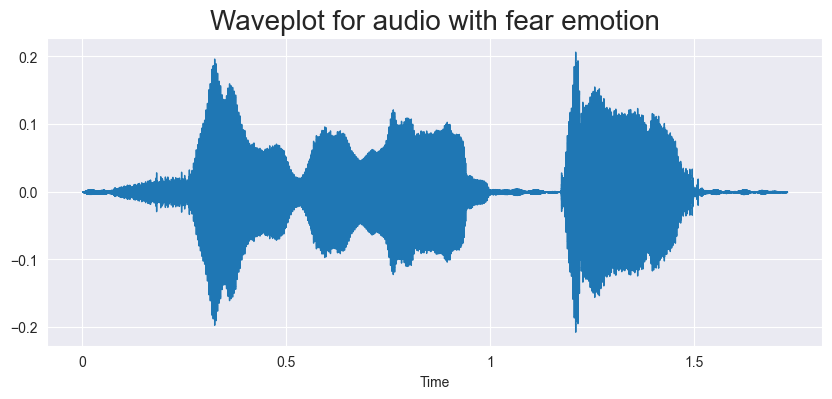

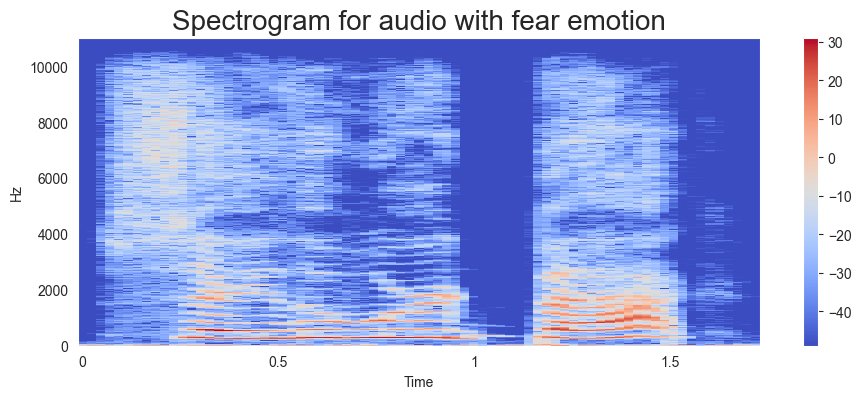

In [51]:
emotion = 'fear'
path = np.array(df_train['speech'][df_train['label'] == emotion])[0]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

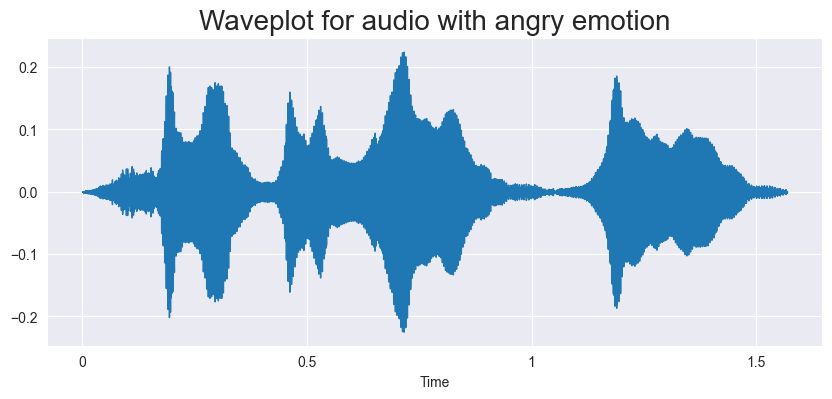

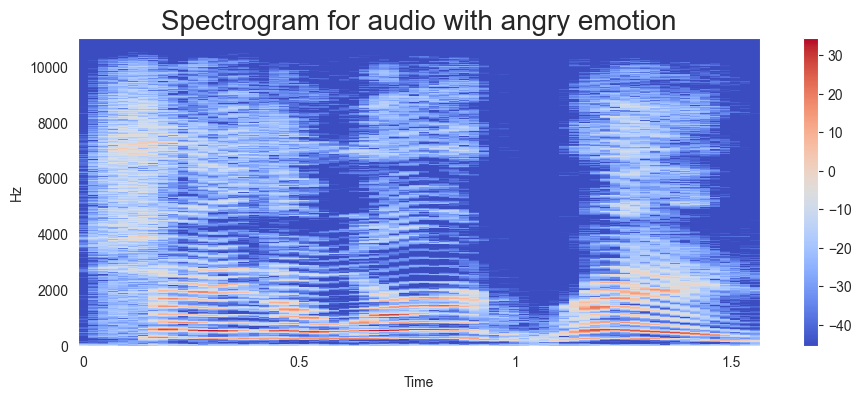

In [52]:
emotion = 'angry'
path = np.array(df_train['speech'][df_train['label'] == emotion])[129]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

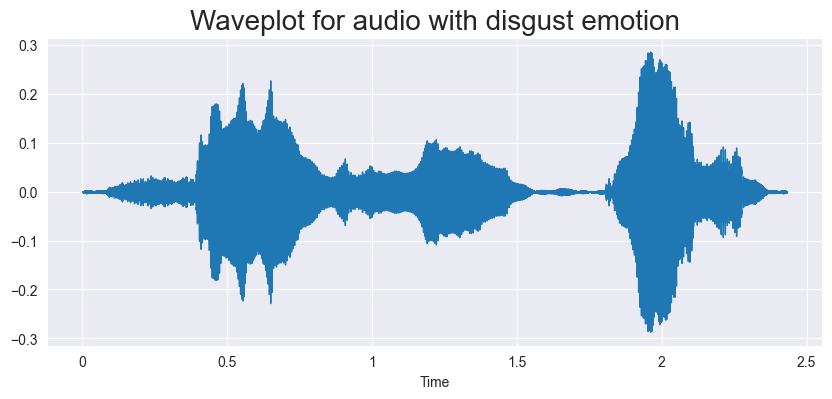

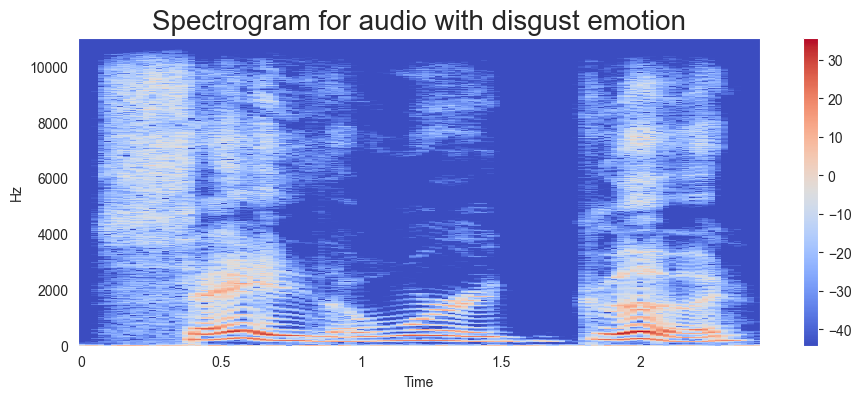

In [53]:
emotion = 'disgust'
path = np.array(df_train['speech'][df_train['label'] == emotion])[51]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

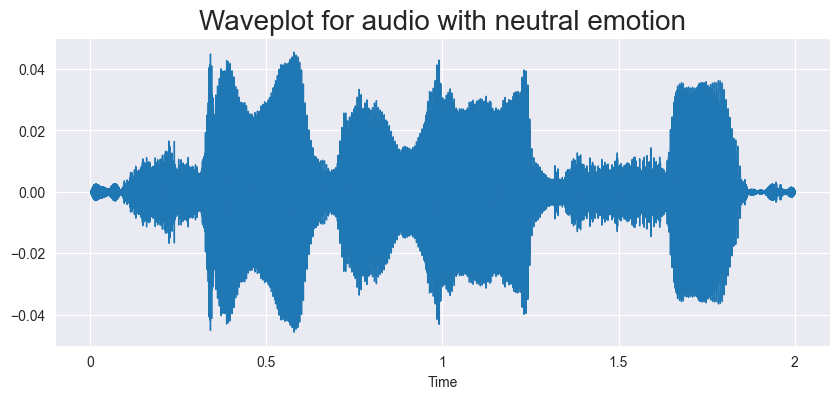

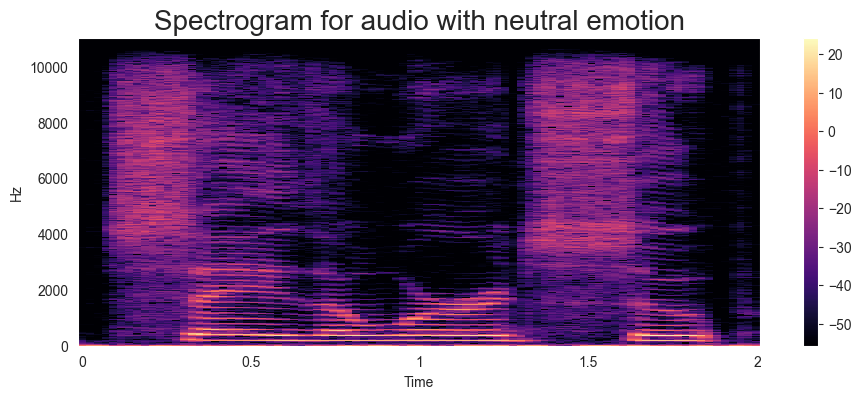

In [54]:
emotion = 'neutral'
path = np.array(df_train['speech'][df_train['label'] == emotion])[157]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

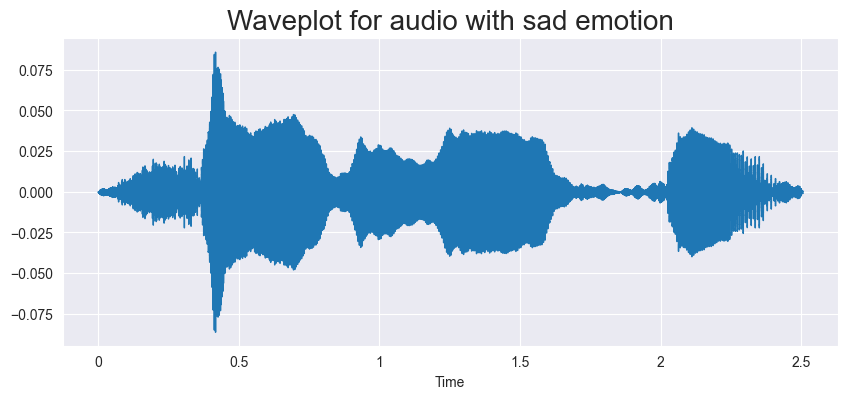

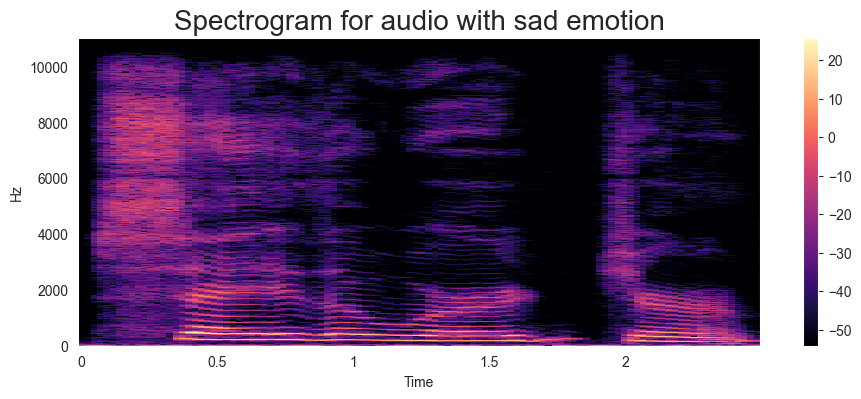

In [55]:
emotion = 'sad'
path = np.array(df_train['speech'][df_train['label'] == emotion])[47]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

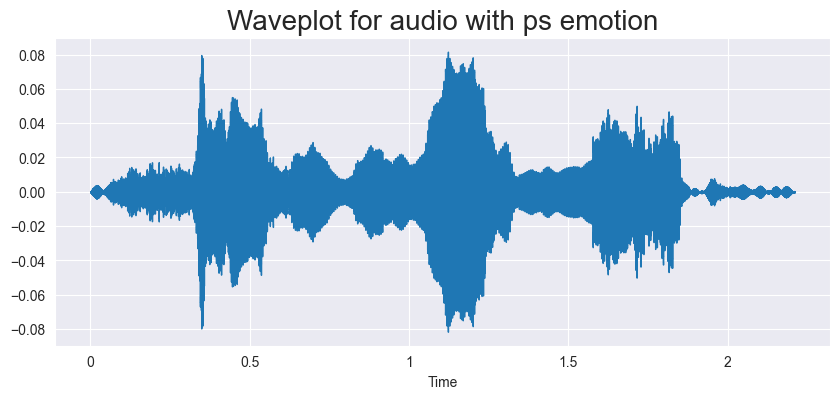

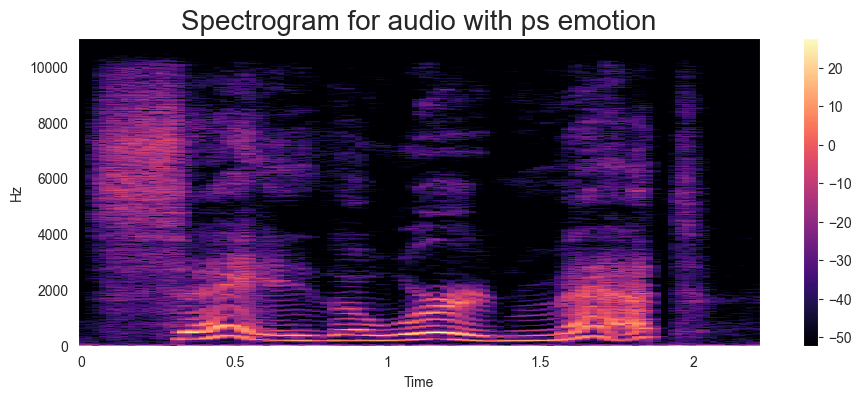

In [56]:
emotion = 'ps'
path = np.array(df_train['speech'][df_train['label'] == emotion])[100]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

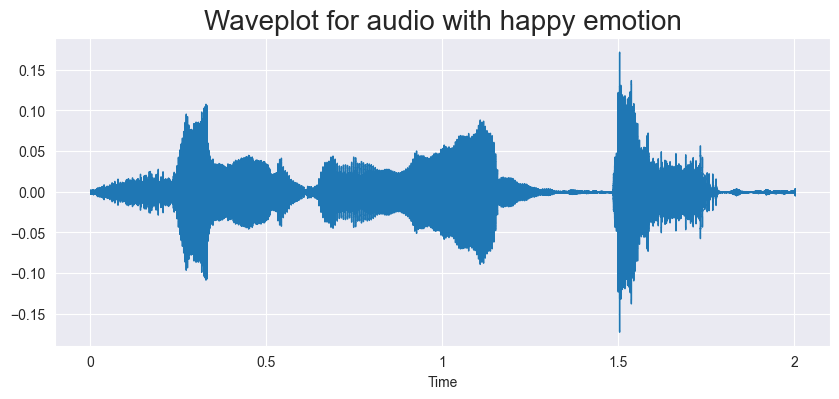

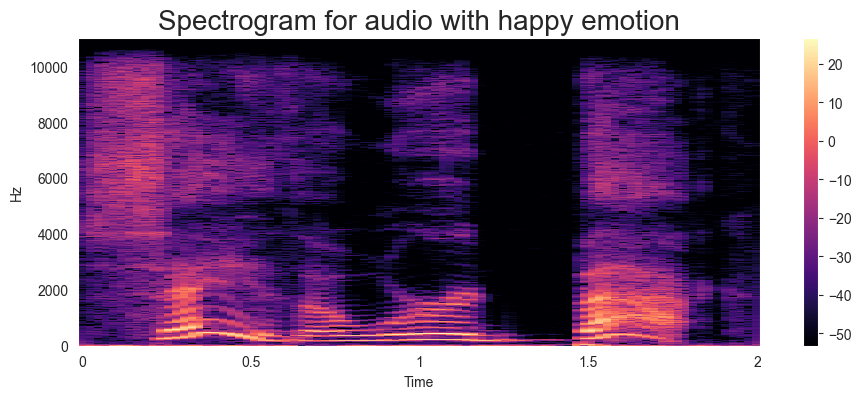

In [57]:
emotion = 'happy'
path = np.array(df_train['speech'][df_train['label'] == emotion])[0]
path

data, sampling_rate = librosa.load(path)
waveform(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

Feature Extraction

In [58]:
def extract_ZCR(signal):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    return zcr

In [59]:
def extract_root_mean_square_value(signal):
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    return rms

In [60]:
def extract_mel_spectrogram(signal, sample_rate):
    mel = np.mean(librosa.feature.melspectrogram(y=signal, sr=sample_rate).T, axis=0)
    return mel

In [61]:
def extract_mfcc(signal, sample_rate):
    # signal, sample_rate = librosa.load(file_name, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfcc

In [62]:
def extract_features(sig, sr):

    result = np.array([])

    # We are stacking the features horizontally

    result = np.hstack((result, extract_ZCR(sig)))
    result = np.hstack((result, extract_mel_spectrogram(sig, sr)))
    result = np.hstack((result, extract_root_mean_square_value(sig)))
    result = np.hstack((result, extract_mfcc(sig, sr)))

    return result

Do a test for one audio file

In [63]:
signal, sample_rate =  librosa.load(df_train['speech'][0], duration=3, offset=0.5)
extract_features(signal, sample_rate)

array([ 5.35156250e-02,  4.54499722e-02,  3.73106170e-03,  6.00405619e-04,
        2.93033168e-04,  8.19421490e-04,  1.02951117e-02,  4.36401069e-02,
        8.37492496e-02,  3.87736857e-01,  1.08909774e+00,  3.39013875e-01,
        7.05446582e-03,  3.24708549e-03,  3.91002931e-03,  9.36311297e-03,
        1.71838515e-02,  6.77124336e-02,  7.03143120e-01,  4.09735680e+00,
        1.80018177e+01,  3.56563148e+01,  4.60170746e+00,  1.40362218e-01,
        1.09326936e-01,  1.04046673e-01,  7.09011331e-02,  6.01135716e-02,
        7.88592994e-02,  2.23462656e-01,  7.05177605e-01,  2.34597802e+00,
        1.62215030e+00,  2.01132327e-01,  2.85724282e-01,  4.83779103e-01,
        5.68572879e-01,  5.98811328e-01,  6.47651434e-01,  4.16560531e-01,
        4.06066060e-01,  1.20294821e+00,  3.96942997e+00,  1.84575343e+00,
        2.17197418e-01,  9.64271650e-02,  1.56728864e-01,  2.68684506e-01,
        4.18750495e-01,  3.37630820e+00,  5.72056484e+00,  3.98652613e-01,
        1.57049559e-02,  

Data augmentation methods

In [64]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [65]:
def stretch(data, rate=0.8):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

In [66]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In case you want to run the code with data augmentation and extract the features for the augmented data, run this part, otherwise go to the next details

Meaning that, we will create new synthetic data by adding some small perturbations to our actual data

In [94]:
def get_features_with_augmentation(file_name):

    signal, sample_rate =  librosa.load(file_name, duration=3, offset=0.5)

    # original data
    result1 = extract_features(signal, sample_rate)
    result = np.array(result1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sampling_rate)
    res3 = extract_features(data_stretch_pitch, sampling_rate)
    result = np.vstack((result, res3))

    return result


If you want to run the feature extraction only for the original data, run the following method


In [68]:
def get_features(file_name):

    signal, sample_rate =  librosa.load(file_name, duration=3, offset=0.5)


    result1 = extract_features(signal, sample_rate)
    result = np.array(result1)


    return result


If you want to extract the features with the augmented data, run this instruction

In [136]:
X, Y = [], []
for path, emotion in zip(train_paths, train_labels):
    feature = get_features_with_augmentation(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

If you want to extract the features only for the original data, run the next two instructions

In [69]:
X = df_train['speech'].apply(lambda x: get_features(x))

In [134]:
Y = df_train['label']

In [137]:
len(X), len(Y)

(8400, 8400)

In [138]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head(2000)

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,labels
0,0.053516,0.045450,0.003731,0.000600,0.000293,0.000819,0.010295,0.043640,0.083749,0.387737,...,5.154173,9.572603,5.408977,2.603453,-1.964724,5.050921,9.097750,2.339435,-2.191724,angry
1,0.142567,0.215363,0.051942,0.002480,0.000670,0.000795,0.034265,0.262885,0.359190,0.129442,...,6.683609,7.542645,7.836293,6.649700,5.790994,5.978873,7.770200,8.443625,8.574472,angry
2,0.106541,0.099176,0.027436,0.000957,0.000268,0.000233,0.002873,0.082783,0.166232,0.039329,...,12.741577,6.406541,9.323278,4.401013,7.516259,5.731200,10.167597,7.939636,7.656004,angry
3,0.057099,0.028428,0.001855,0.000360,0.000306,0.001112,0.009607,0.027762,0.059205,0.158610,...,8.821530,12.103997,2.990492,2.146510,-2.459835,2.133901,8.542202,4.342046,3.063363,angry
4,0.127475,0.215417,0.051865,0.002425,0.000629,0.000739,0.034258,0.262336,0.358486,0.129657,...,7.104924,8.239263,8.328144,7.244203,6.594791,5.977070,7.472248,8.003959,9.195539,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.092074,0.026849,0.001269,0.000291,0.000339,0.006766,0.152249,0.241526,0.116254,0.184280,...,5.366159,2.214368,1.911358,-0.581576,4.069022,0.752860,4.370569,7.574412,11.460463,happy
1996,0.226983,0.217738,0.053059,0.003020,0.001096,0.001556,0.035640,0.266554,0.361302,0.130574,...,4.798711,5.734961,5.870677,5.047336,3.526511,4.086906,4.964237,5.448535,6.172462,happy
1997,0.103948,0.123340,0.026768,0.000974,0.000314,0.000299,0.006554,0.132071,0.121815,0.055866,...,13.349934,6.718412,9.161206,4.223049,7.184810,6.551106,9.777954,7.215525,7.536006,happy
1998,0.069972,0.025969,0.001491,0.000953,0.000891,0.009309,0.048253,0.114918,0.076218,0.102090,...,8.018329,3.355166,2.467667,-2.801525,3.801204,3.337063,6.267555,2.774435,9.204553,happy


The following step is -> Data Preparation

So, we need to prepare the feature data we extracted in order to can use our model with it.

In [143]:
# First, we split the data in: feature values and labels separately

X = Features.iloc[:, :-1].values
Y = Features['labels'].values

In [144]:
X.shape

(8400, 170)

In [145]:
Y

array(['angry', 'angry', 'angry', ..., 'sad', 'sad', 'sad'], dtype=object)

In [146]:
enc = OneHotEncoder()
y_train = enc.fit_transform(Y.reshape(-1, 1))

In [147]:
y_train.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [148]:
## 2800 - the number of samples
## 7 - the number of categories we have
y_train.shape

(8400, 7)

We make our data compatible with the model

If the extracted features were only for the original data run this instruction

In [85]:
X = [x[0] for x in X]
X = np.array(X)
X.shape

(2800, 170)

If the extracted features were also for the augmented data, run this instruction

In [149]:
X = [x for x in X]
X = np.array(X)
X.shape

(8400, 170)

Now we prepare the data for our model and split it

In [150]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, y_train, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 170), (6300, 7), (2100, 170), (2100, 7))

In [151]:
# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 170), (6300, 7), (2100, 170), (2100, 7))

In [152]:
# Expands data dimension
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 170, 1), (6300, 7), (2100, 170, 1), (2100, 7))

Run this model if you want to use the Categorical Cross Entropy as loo function

In [153]:
model=Sequential()

model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=7, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 170, 128)          66560     
                                                                 
 lstm_15 (LSTM)              (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 7)                 231       
                                                                 
Total params: 202,503
Trainable params: 202,503
Non-trainable params: 0
_________________________________________________________________


Run this model if you want to use Mean Squared Logarithmic Error as loss function

In [ ]:
model=Sequential()

model.add(LSTM(128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=7, activation=None))

msle = tf.keras.losses.MeanSquaredLogarithmicError()
model.compile(optimizer = 'adam' , loss = msle , metrics = ['accuracy'])

model.summary()

In [154]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=0, patience=4, min_lr=0.0000001)

history=model.fit(x_train, y_train.todense(), batch_size=256, epochs=50, validation_data=(x_test, y_test.todense()), callbacks=[rlrp], shuffle=True)

History = pd.DataFrame(history.history)
History.to_csv('training_model_experiment_x.csv', index=False)
History.head(2000)

Epoch 1/50
25/25 [==============================] - 49s 2s/step - loss: 1.8075 - accuracy: 0.2422 - val_loss: 1.6253 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 46s 2s/step - loss: 1.5630 - accuracy: 0.3379 - val_loss: 1.4679 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 46s 2s/step - loss: 1.4429 - accuracy: 0.3846 - val_loss: 1.4051 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 47s 2s/step - loss: 1.3984 - accuracy: 0.3954 - val_loss: 1.3965 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 47s 2s/step - loss: 1.3809 - accuracy: 0.4106 - val_loss: 1.3956 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 47s 2s/step - loss: 1.3768 - accuracy: 0.4089 - val_loss: 1.3833 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 7/50
25/25 [==============================] - 47s 2s/step - loss: 1.3579 - a

,loss,accuracy,val_loss,val_accuracy,lr
0,1.807483,0.242222,1.625327,0.321429,1.000000e-03
1,1.563030,0.337937,1.467862,0.376190,1.000000e-03
2,1.442882,0.384603,1.405115,0.388571,1.000000e-03
3,1.398381,0.395397,1.396510,0.389048,1.000000e-03
4,1.380949,0.410635,1.395604,0.386667,1.000000e-03
5,1.376842,0.408889,1.383302,0.386190,1.000000e-03
6,1.357873,0.414127,1.395082,0.392381,1.000000e-03
7,1.361996,0.417302,1.370720,0.401905,1.000000e-03
8,1.345180,0.420159,1.372893,0.407619,1.000000e-03
9,1.343337,0.420159,1.372077,0.397619,1.000000e-03


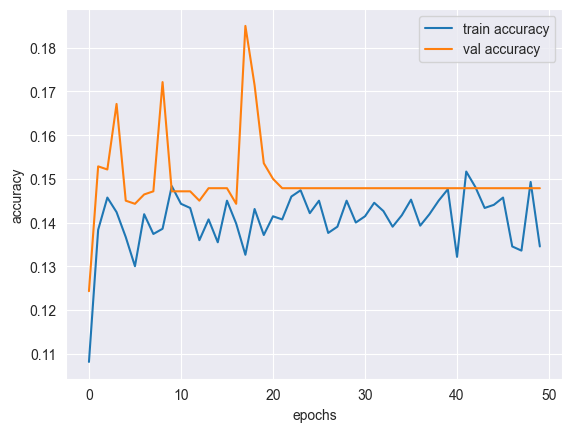

In [259]:
## Plot the results

epochs = list(range(50))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

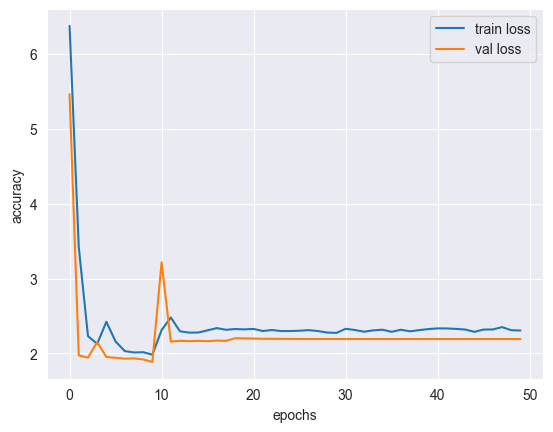

In [260]:
## Plot the results

epochs = list(range(50))

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [261]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(pred_test)
y_test = enc.inverse_transform(y_test)

44/44 [==============================] - 5s 90ms/step


In [262]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,disgust,happy
2,neutral,fear
3,neutral,fear
4,disgust,angry
...,...,...
95,disgust,sad
96,disgust,neutral
97,disgust,angry
98,neutral,fear


We compute the confusion matrix

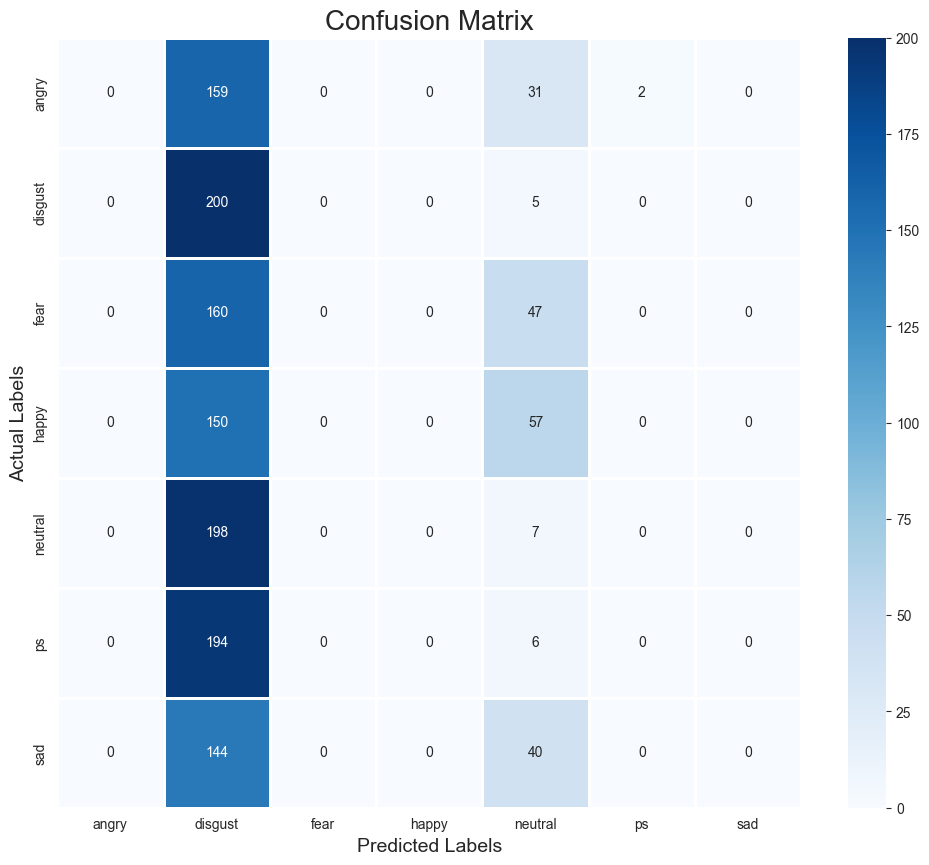

In [263]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

We print the classification report

In [264]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       192
     disgust       0.17      0.98      0.28       205
        fear       0.00      0.00      0.00       207
       happy       0.00      0.00      0.00       207
     neutral       0.04      0.03      0.04       205
          ps       0.00      0.00      0.00       200
         sad       0.00      0.00      0.00       184

    accuracy                           0.15      1400
   macro avg       0.03      0.14      0.05      1400
weighted avg       0.03      0.15      0.05      1400



We save the model

In [265]:
model.save("training_model_experiment_x.h5")